In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/CV/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


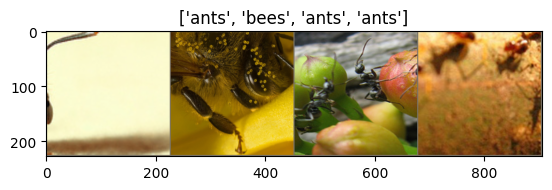

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

2.2%

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ktg02/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5418 Acc: 0.7049
val Loss: 0.1909 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5639 Acc: 0.7828
val Loss: 0.1827 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5677 Acc: 0.7623
val Loss: 0.5228 Acc: 0.8105

Epoch 3/24
----------
train Loss: 0.6503 Acc: 0.7705
val Loss: 0.2654 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.6001 Acc: 0.7746
val Loss: 0.4436 Acc: 0.8366

Epoch 5/24
----------
train Loss: 0.3534 Acc: 0.8648
val Loss: 0.2583 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.3890 Acc: 0.8320
val Loss: 0.2736 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3982 Acc: 0.8689
val Loss: 0.2587 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3398 Acc: 0.8730
val Loss: 0.2319 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2744 Acc: 0.8730
val Loss: 0.2011 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3257 Acc: 0.8811
val Loss: 0.2206 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3007 Acc: 0.8730
val Loss: 0.1940 Acc: 0.9412

Ep

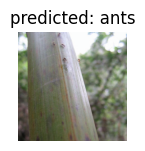

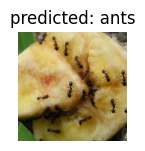

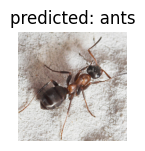

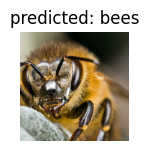

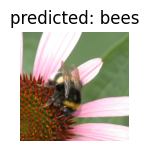

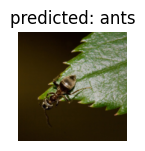

In [9]:
visualize_model(model_ft)

In [10]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7221 Acc: 0.6066
val Loss: 0.2310 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.5737 Acc: 0.7418
val Loss: 0.2938 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4347 Acc: 0.8033
val Loss: 0.1948 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.6236 Acc: 0.7295
val Loss: 0.3510 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.4303 Acc: 0.8115
val Loss: 0.2117 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5011 Acc: 0.7787
val Loss: 0.2823 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.4270 Acc: 0.8197
val Loss: 0.1794 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3245 Acc: 0.8525
val Loss: 0.1958 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3320 Acc: 0.8361
val Loss: 0.2029 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3833 Acc: 0.8484
val Loss: 0.2257 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3167 Acc: 0.8893
val Loss: 0.1826 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.2930 Acc: 0.8730
val Loss: 0.1781 Acc: 0.9542

Ep

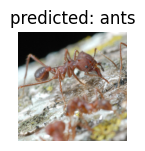

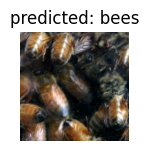

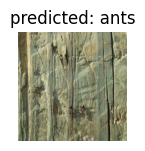

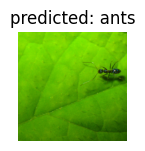

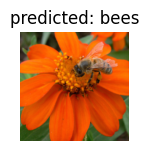

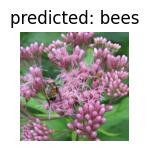

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [13]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

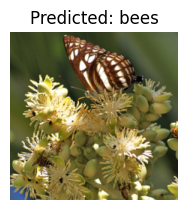

In [15]:
visualize_model_predictions(
    model_conv,
    img_path='data/CV/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()